In [1]:
%reload_ext autoreload
%autoreload 2

import vtk
from vtk.util import numpy_support

import numpy as np
import bloscpack as bp
import time
import sys
import os
sys.path.append(os.path.join(os.environ['REPO_DIR'], 'utilities'))

from utilities2015 import *
from annotation_utilities import *
from metadata import *
from data_manager import *

import matplotlib.pyplot as plt
%matplotlib inline

from vis3d_utilities import *

Setting environment for Local Macbook Pro


In [2]:
stack = 'MD589'

# Visualize thumbnail volume itself

In [20]:
tb_volume = DataManager.load_intensity_volume(stack=stack)

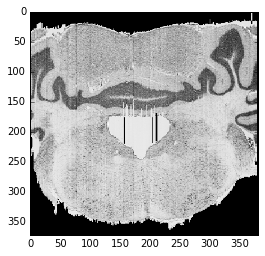

In [31]:
plt.imshow(tb_volume[:,250,:], plt.cm.gray)

In [5]:
launch_vtk([actor_volume(tb_volume[:,:,tb_volume.shape[2]*1/3:], what='tb', tb_opacity=0.5)], 
           window_name='Thumbnail Volume %(stack)s' % {'stack': stack},
          init_angle='45')

# Visualize thumbnail volume with annotation contours

In [6]:
contour_df_rel2uncropped = DataManager.load_annotation_v4(stack=stack, suffix='contours', timestamp='latest')

aws s3 cp --recursive "s3://mousebrainatlas-data/CSHL_labelings_v3/MD589" "/home/yuncong/CSHL_labelings_v3/MD589" --exclude "*" --include "*contours*"
latest timestamp:  10042017100807


In [7]:
contour_df_rel2cropped = convert_annotation_v3_original_to_aligned_cropped(contour_df_rel2uncropped, stack=stack)

In [8]:
from skimage.draw import polygon_perimeter

In [9]:
tb_volume = DataManager.load_intensity_volume(stack=stack)
tb_vol_ydim, tb_vol_xdim, tb_vol_zdim = tb_volume.shape

In [10]:
tb_volume = tb_volume.astype(np.float32)

In [11]:
# Make contours have value x.5 (between integers)
structure_to_value = {name_u: i % len(all_known_structures_sided) + 1.5 
                      for i, name_u in enumerate(all_known_structures)}

In [12]:
for i, name_u in enumerate(all_known_structures):

    matched_contours = contour_df_rel2cropped[(contour_df_rel2cropped['name'] == name_u)]
    
    for cnt_id, cnt in matched_contours.iterrows():
        fn = cnt['filename']
        if fn not in metadata_cache['valid_filenames'][stack]:
            continue
        section = metadata_cache['filenames_to_sections'][stack][fn]
        z = int(np.mean(DataManager.convert_section_to_z(stack=stack, sec=section, downsample=32)))
        n = len(cnt['vertices'])
        contour_3d = np.c_[cnt['vertices']/32, z*np.ones((n,))].astype(np.int)
        
        polygon_ys, polygon_xs = polygon_perimeter(contour_3d[:,1], contour_3d[:,0])
        valid = (polygon_ys >= 0) & (polygon_ys < tb_vol_ydim) & (polygon_xs >= 0) & (polygon_xs < tb_vol_xdim)
                
        tb_volume[polygon_ys[valid], polygon_xs[valid], z] = structure_to_value[name_u]

In [13]:
# All contours in red
# tb_colors = {i % len(structures) + 1.5: (1.,0,0) for i, name_u in enumerate(structures)}

# Different structures in different color
# tb_colors = {i % len(structures) + 1.5: np.random.randint(0, 255, (3,))/255. for i, name_u in enumerate(structures)}
# tb_colors = {i % len(all_known_structures) + 1.5: np.array(high_contrast_colors[np.random.randint(0, len(high_contrast_colors), 1)])/255. 
#              for i, name_u in enumerate(all_known_structures)}

tb_colors = {i % len(all_known_structures) + 1.5: np.array(name_unsided_to_color[name_u])/255. 
             for i, name_u in enumerate(all_known_structures)}

In [14]:
launch_vtk([actor_volume(tb_volume, 'tb', tb_colors=tb_colors)], init_angle='45')

In [15]:
cut_z = 100
cut_xmin = 50
cut_xmax = 500

In [16]:
tb_volume_half = tb_volume.copy()
tb_volume_half[:, :, :cut_z] = 0
tb_volume_half[:, :cut_xmin, :] = 0
tb_volume_half[:, cut_xmax:, :] = 0

launch_vtk([actor_volume(tb_volume_half, 'tb', tb_colors=tb_colors)], init_angle='45')

In [17]:
tb_volume_sectioned = np.zeros_like(tb_volume)
interval = 10
# for z in range(tb_volume_sectioned.shape[2]/2, tb_volume_sectioned.shape[2], interval):
for z in range(cut_z, tb_volume_sectioned.shape[2], interval):
    tb_volume_sectioned[:, :, z:z+3] = tb_volume[:,:,z:z+3]

In [18]:
launch_vtk([actor_volume(tb_volume_sectioned, 'tb', tb_colors=tb_colors)], init_angle='45')

In [19]:
tb_volume_piece = tb_volume[:,cut_xmin:cut_xmax+1,:cut_z+5].copy()
tb_volume_piece[:, :, :cut_z] = 0

launch_vtk([actor_volume(tb_volume_piece, 'tb', tb_colors=tb_colors, origin=(50,0,0), tb_opacity=.4),
           actor_volume(tb_volume_sectioned, 'tb', tb_colors=tb_colors, tb_opacity=.01)],
          init_angle='45')

In [260]:
# Plot VTK transfer function

# compositeOpacity = vtk.vtkPiecewiseFunction()
# compositeOpacity.AddPoint(0.0, 0.)
# for v, c in sorted(tb_colors.items()):
#     vl = v - .5
#     vr = v + .5
#     cp1 = vl-.25
#     cp2 = vr-.25
#     compositeOpacity.AddPoint(cp1, .5*cp1/200., .5, 1.)
#     compositeOpacity.AddPoint(v, 1., .5, 1.)
#     compositeOpacity.AddPoint(cp2, .5*cp2/200., .5, 1.)
# compositeOpacity.AddPoint(vr, .5*vr/200.)
# compositeOpacity.AddPoint(240., 0.05)
# compositeOpacity.AddPoint(255.0, 0.05)

# q = np.array([compositeOpacity.GetValue(v) for v in np.arange(0, 255, .1)])

# plt.figure(figsize=(20,5));
# plt.plot(np.arange(0, 255, .1), q);